### Load Modules

In [252]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
from nltools.stats import isc, threshold, fdr, fisher_r_to_z, fisher_z_to_r
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nilearn.plotting import view_img_on_surf, view_img
import nilearn
import numpy as np
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests


### Setup folders and prepare mask

In [253]:
folder_path = '../data/00_raw_fmri/'  # <-- change to your folder
raw_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.npy') and "._" not in file:
            raw_files.append(file[5:12])

raw_files.sort()
raw_files[:3]


schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)
schaefer_rois_file       = schaefer['maps']

# set up mask
mask = Brain_Data(schaefer['maps'])
mask_x = expand_mask(mask)

/Users/schmaelz/miniconda3/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


In [254]:
raw_files[:3]

['s01e01a', 's01e01b', 's01e02a']

### Load ISC results

In [255]:
laughter_iscs = []
no_laughter_iscs = []

for curr_show_index in tqdm(range(len(raw_files))):
    curr_show_name = raw_files[curr_show_index]
    
    out_name1 = '../data/02_laughter/laughter_iscs/' + curr_show_name + '_laughter_segment_isc.npy'
    if os.path.exists(out_name1):
        laughter_iscs.append(fisher_r_to_z(np.load(out_name1)))
    
    out_name2 = '../data/02_laughter/laughter_iscs/' + curr_show_name + '_no_laughter_segment_isc.npy'
    if os.path.exists(out_name2):
        no_laughter_iscs.append(fisher_r_to_z(np.load(out_name2)))

laughter_iscs = np.asarray(laughter_iscs)
no_laughter_iscs = np.asarray(no_laughter_iscs)

print(laughter_iscs.shape)
print(no_laughter_iscs.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 879.84it/s]

(280, 1000)
(280, 1000)


### Plot

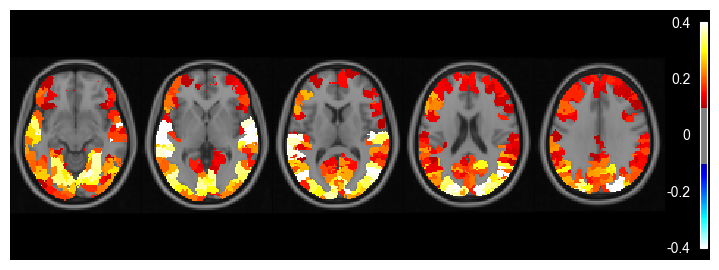

In [256]:
laughter_isc_average = fisher_z_to_r(np.mean(laughter_iscs, axis=0))
laughter_isc_average.shape

isc_r_brain = roi_to_brain(pd.Series(laughter_isc_average), mask_x).to_nifti()
#result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = alpha)).to_nifti()

fig = plt.figure(figsize=(7, 2.5))
nilearn.plotting.plot_stat_map(    isc_r_brain, 
                                       bg_img       = '../data/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.1,  #additional threshold for visualization
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ -10, 0, 10, 20, 30],
                                       annotate     = False,
                                       figure = fig);#,
                                       #title = 'ISC Laughter Scenes (across episodes)');

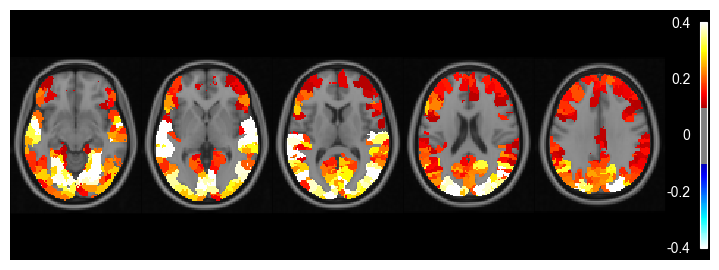

In [258]:
no_laughter_isc_average = fisher_z_to_r(np.mean(no_laughter_iscs, axis=0))

isc_r_brain = roi_to_brain(pd.Series(no_laughter_isc_average), mask_x).to_nifti()
#result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = alpha)).to_nifti()

fig = plt.figure(figsize=(7, 2.5))
nilearn.plotting.plot_stat_map(    isc_r_brain, 
                                       bg_img       = '../data/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.1,  #additional threshold for visualization
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ -10, 0, 10, 20, 30],
                                       annotate     = False,
                                       figure = fig)
                                       #title = 'ISC No-Laughter Scenes (across episodes)');

In [259]:
isc_difference =  fisher_z_to_r(np.mean(laughter_iscs, axis=0) - np.mean(no_laughter_iscs, axis=0) )

# Perform paired t-test for each region (axis=0 across subjects)
t_values = np.zeros(1000)
p_values = np.zeros(1000)

for i in range(1000): # regions
    t_stat, p_val = ttest_rel(laughter_iscs[:, i], no_laughter_iscs[:, i])
    t_values[i] = t_stat
    p_values[i] = p_val

# Now you have arrays of t-values and p-values for each region
print(t_values.shape)  # (1000,)
print(p_values.shape)  # (1000,)

significant_mask, pvals_corrected, _, _ = multipletests(p_values, alpha=0.001, method='fdr_bh')
#significant_mask = np.ones(1000, dtype=bool)
# Which regions are significant?
#significant_indices = np.where(significant_mask)[0]

significant_isc_differences = np.zeros((1000,))
significant_isc_differences[significant_mask] = isc_difference[significant_mask]

isc_r_brain = roi_to_brain(pd.Series(significant_isc_differences), mask_x).to_nifti()
#result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = alpha)).to_nifti()


(1000,)
(1000,)


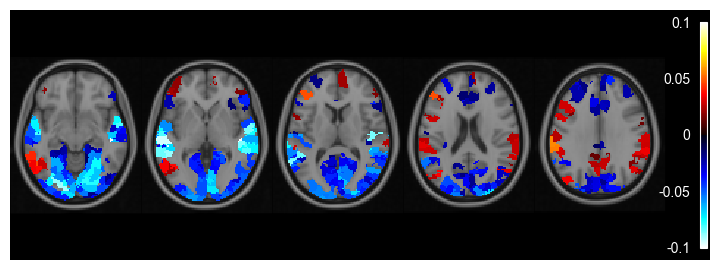

In [260]:
fig = plt.figure(figsize=(7, 2.5))
display = nilearn.plotting.plot_stat_map(    isc_r_brain, 
                                       bg_img       = '../data/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.0,  #additional threshold for visualization
                                       vmax         = 0.1, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ -10, 0, 10, 20, 30],
                                       annotate     = False,
                                       figure = fig)
                                       #title = 'ISC No-Laughter Scenes (across episodes)');


# Add overlay to the same display
#overlay_img = '../data/tpj_association-test_z_FDR_0.01.nii.gz'
#display.add_overlay(overlay_img, cmap='Greens', threshold=0.1, alpha=0.6)

/Users/schmaelz/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/schmaelz/miniconda3/lib/python3.10/site-packages/nilearn/plotting/html_document.py:65: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



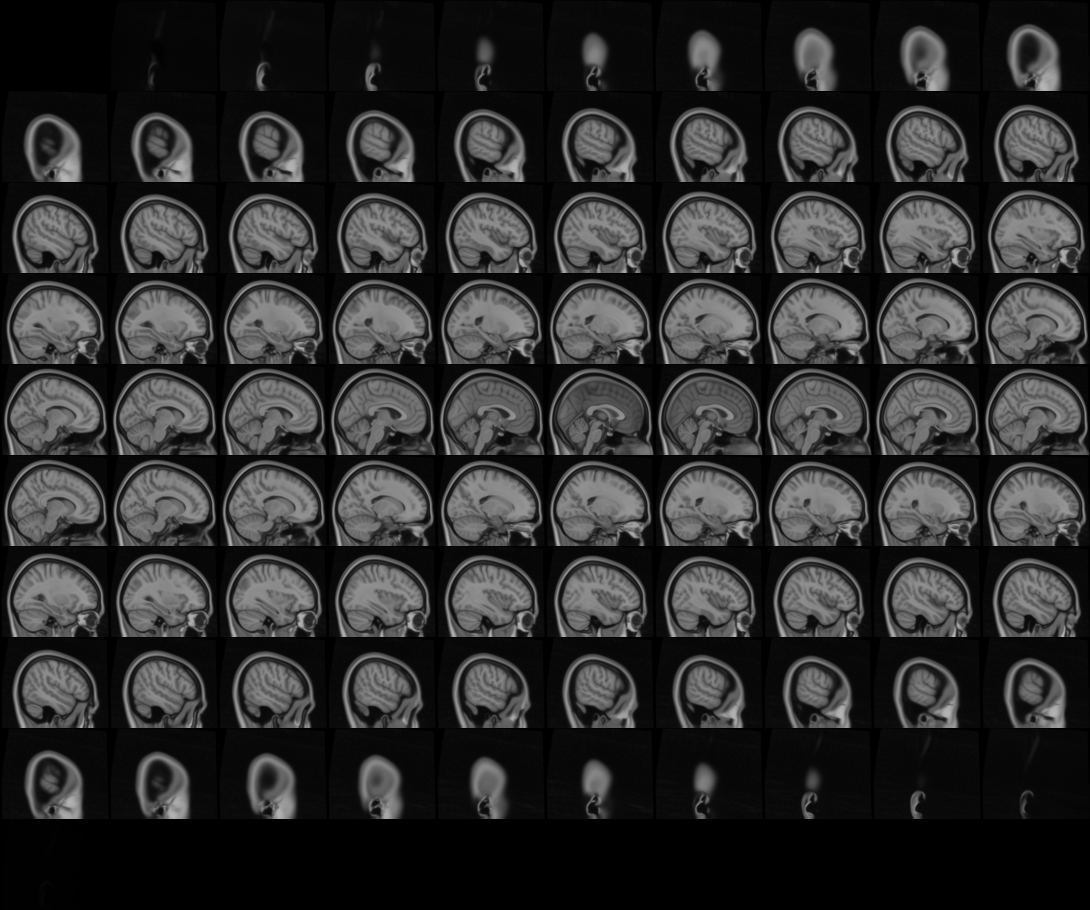
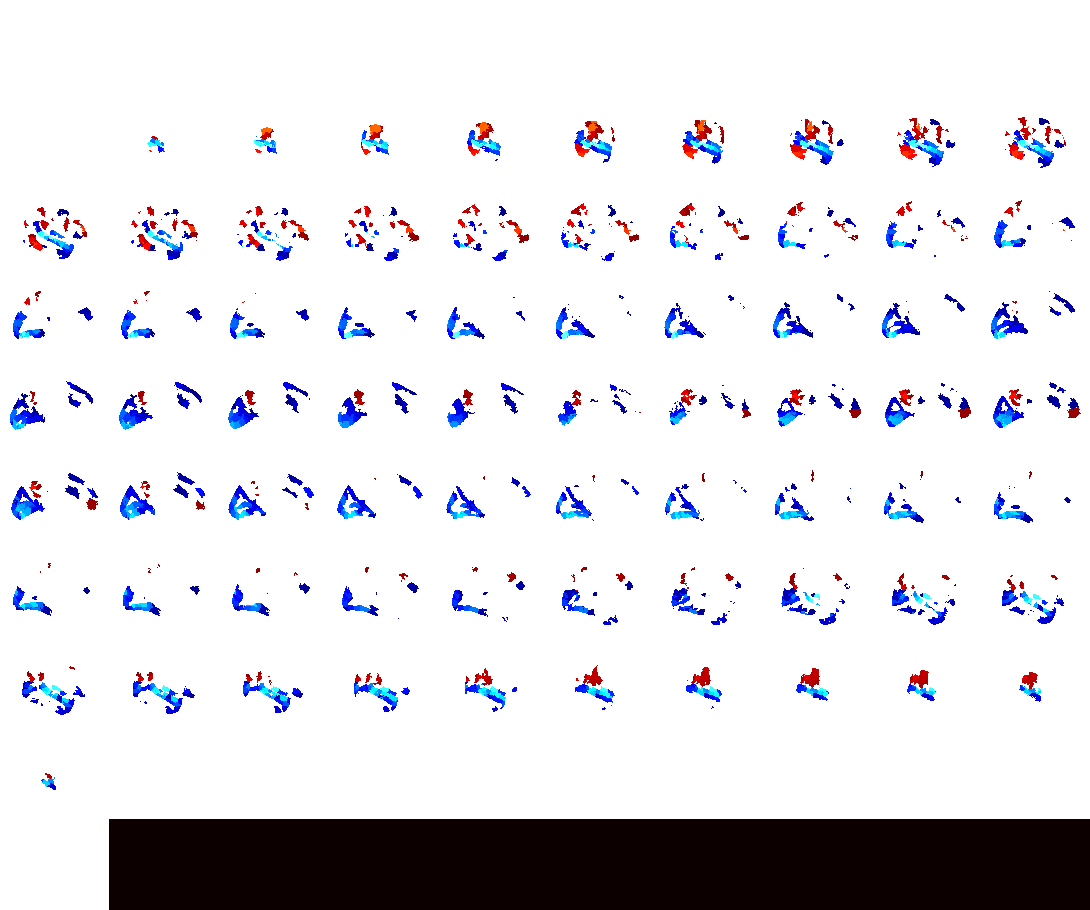

In [262]:
view = nilearn.plotting.view_img( isc_r_brain, 
                                  bg_img  = '../data/MNI152_T1_2mm.nii.gz',
                                  threshold=0.00);


view

In [92]:
isc_r_brain.to_filename('corrisc.nii')

In [75]:

# Your list or array of p-values
pvals = [0.01, 0.04, 0.03, 0.2, 0.0001]

# FDR correction (Benjamini-Hochberg)

# Use as needed
print("Significant mask:", significant_mask)
print("Corrected p-values:", pvals_corrected)


Significant mask: [ True  True  True False  True]
Corrected p-values: [0.025  0.05   0.05   0.2    0.0005]


In [41]:
isc_r_brain.to_filename('../data/tmap.nii')

/Users/schmaelz/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/schmaelz/miniconda3/lib/python3.10/site-packages/nilearn/image/resampling.py:291: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
/Users/schmaelz/miniconda3/lib/python3.10/site-packages/nilearn/plotting/html_document.py:65: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



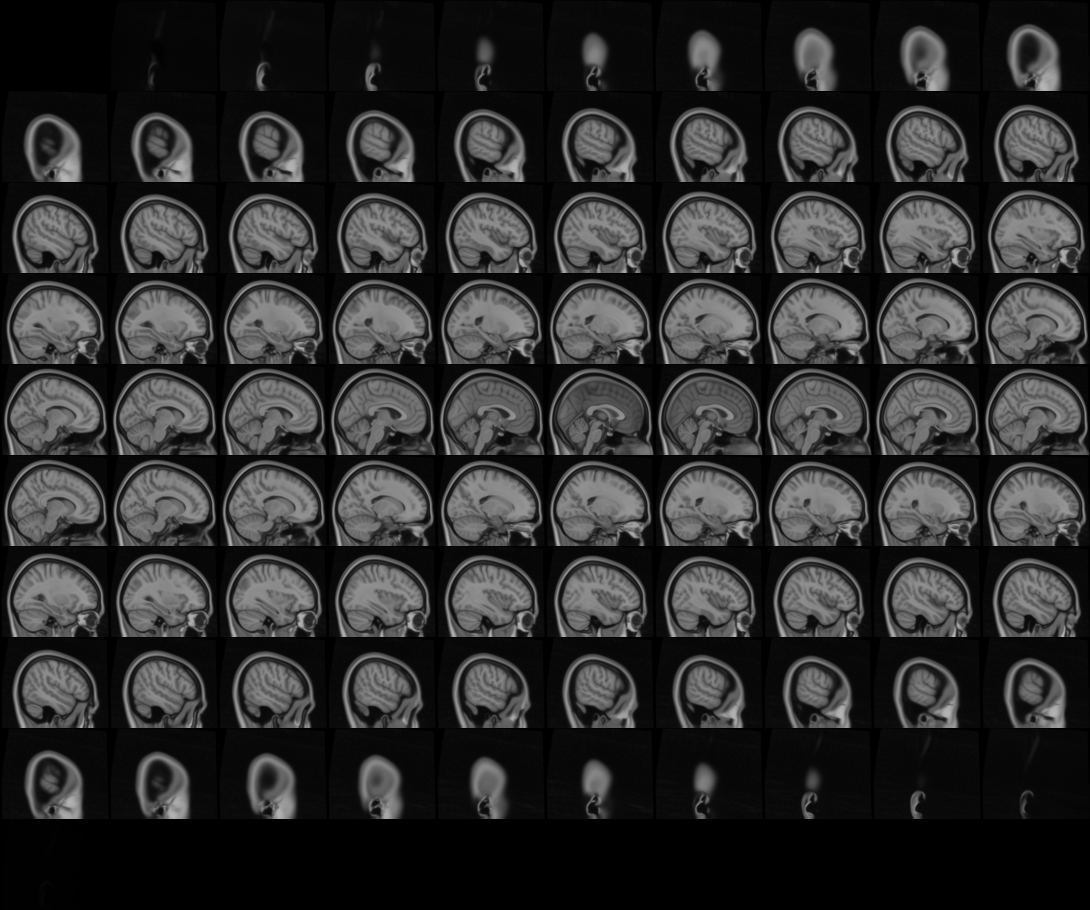
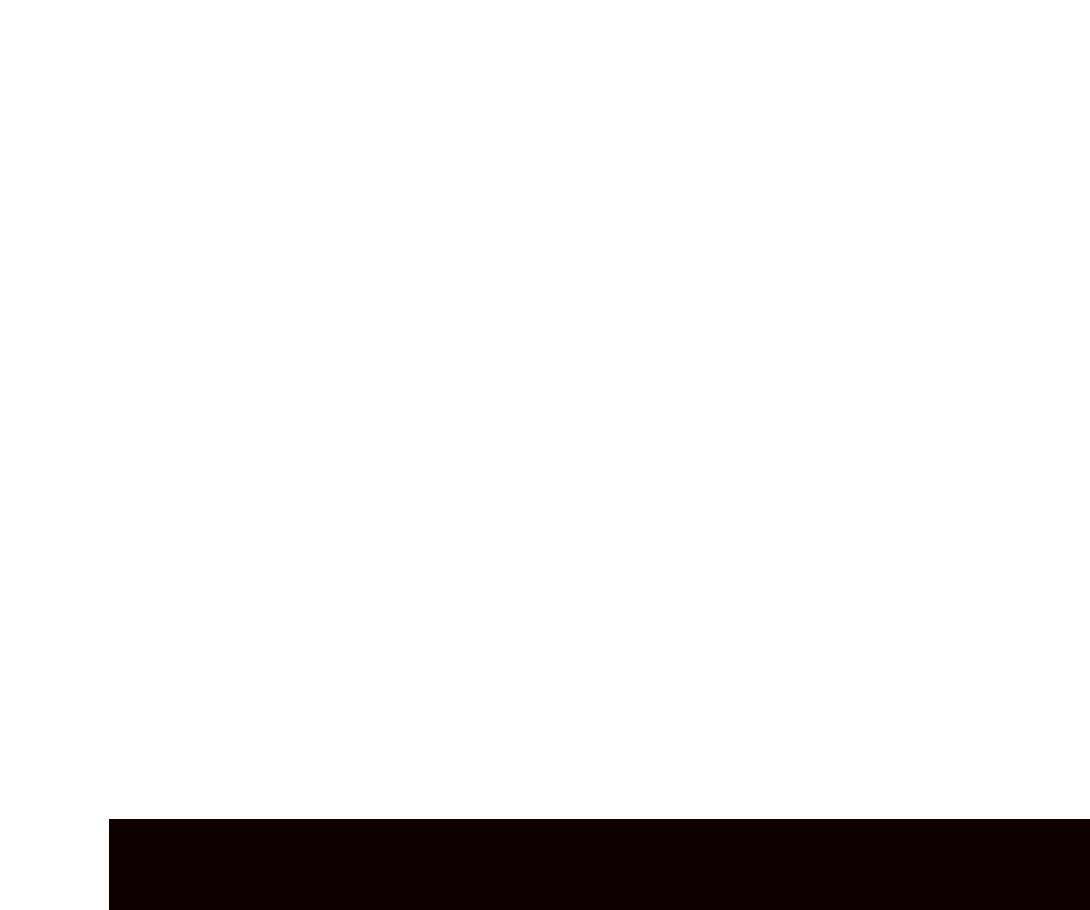

In [249]:
rtpj_index = 843
one_isc_result = np.zeros(1000)
one_isc_result[rtpj_index] = 1 
isc_r_brain = roi_to_brain(pd.Series(one_isc_result), mask_x).to_nifti()
# visualize results
view = nilearn.plotting.view_img( isc_r_brain, 
                           bg_img       = '../data/MNI152_T1_2mm.nii.gz');
#overlay_img = '../data/tpj_association-test_z_FDR_0.01.nii.gz'
#img.add_overlay(overlay_img, cmap='Greens', threshold=0.1, alpha=0.6)
isc_r_brain.to_filename('../data/843roi.nii')
view



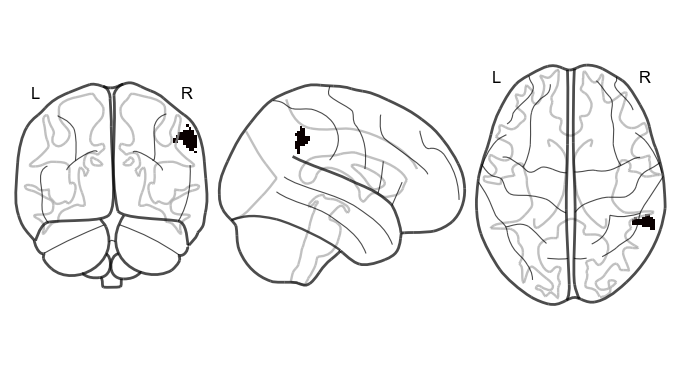

In [251]:
nilearn.plotting.plot_glass_brain(isc_r_brain)

In [162]:
no_laughter_isc_average[rtpj_index]

0.1059160406144352

In [163]:
laughter_isc_average[rtpj_index]

0.1203180724902983

In [164]:
rtpj_laughter    = fisher_z_to_r(laughter_iscs[:,rtpj_index])
rtpj_no_laughter = fisher_z_to_r(no_laughter_iscs[:,rtpj_index])


In [165]:
rtpj_df = pd.DataFrame()
rtpj_df['laughter'] = rtpj_laughter
rtpj_df['no_laughter'] = rtpj_no_laughter
rtpj_df

,laughter,no_laughter
0,0.052829,0.032473
1,0.053879,0.021057
2,0.064962,0.190391
3,0.123672,0.092753
4,0.078021,0.043006
...,...,...
275,0.095878,0.081034
276,0.137812,0.063607
277,0.133428,0.079996
278,0.100521,0.039809


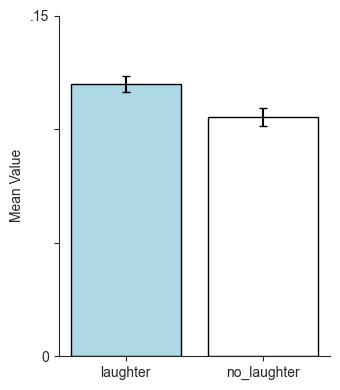

In [184]:
# Compute means and stds
means = rtpj_df[['laughter', 'no_laughter']].mean()
stds = rtpj_df[['laughter', 'no_laughter']].std()
sems = rtpj_df[['laughter', 'no_laughter']].sem()

import seaborn as sns
sns.set_style('ticks')

# Bar plot
labels = ['laughter', 'no_laughter']
x = np.arange(len(labels))

plt.figure(figsize=(3.5, 4))
plt.bar(x, means, yerr=sems, capsize=3, color=['lightblue', 'white'], edgecolor='black')
plt.xticks(x, labels)
plt.ylabel('Mean Value')
plt.ylim([0, 0.15])
plt.yticks([0, 0.05, 0.1, 0.15], ['0', '', '', '.15'])


#plt.title('Laughter vs No Laughter')
plt.tight_layout()
sns.despine()
plt.show()

In [192]:
df_names = pd.DataFrame(raw_files, columns = ['names'])
df_names['season'] = df_names['names'].str.extract(r'(s\d{2})')
df_names.head()

,names,season
0,s01e01a,s01
1,s01e01b,s01
2,s01e02a,s01
3,s01e02b,s01
4,s01e03a,s01


In [205]:
df_merged = pd.concat([df_names.reset_index(drop=True), rtpj_df.reset_index(drop=True)], axis=1)
df_merged.head()


,names,season,laughter,no_laughter
0,s01e01a,s01,0.052829,0.032473
1,s01e01b,s01,0.053879,0.021057
2,s01e02a,s01,0.064962,0.190391
3,s01e02b,s01,0.123672,0.092753
4,s01e03a,s01,0.078021,0.043006


In [206]:
df_merged['laughter'].mean()

0.1198818606099632

In [207]:
df_merged['no_laughter'].mean()

0.10543498375314417

In [214]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group and aggregate
agg_df = df_merged.groupby('season')[['laughter', 'no_laughter']].agg(['mean', 'sem']).reset_index()
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]
                  
agg_df




,season,laughter_mean,laughter_sem,no_laughter_mean,no_laughter_sem
0,s01,0.103042,0.007587,0.090040,0.008128
1,s02,0.105635,0.009396,0.108330,0.008218
2,s03,0.126176,0.009090,0.111864,0.010995
3,s04,0.129623,0.009041,0.112917,0.012150
4,s05,0.124390,0.007263,0.098340,0.008545
5,s06,0.132187,0.008610,0.111700,0.008439


In [215]:

# Create a long-format DataFrame manually (no melt)
mean_df = pd.DataFrame({
    'season': pd.concat([agg_df['season'], agg_df['season']]),
    'condition': ['laughter'] * len(agg_df) + ['no_laughter'] * len(agg_df),
    'ISC': pd.concat([agg_df['laughter_mean'], agg_df['no_laughter_mean']]),
    'sem': pd.concat([agg_df['laughter_sem'], agg_df['no_laughter_sem']])
})
mean_df

,season,condition,ISC,sem
0,s01,laughter,0.103042,0.007587
1,s02,laughter,0.105635,0.009396
2,s03,laughter,0.126176,0.009090
3,s04,laughter,0.129623,0.009041
4,s05,laughter,0.124390,0.007263
5,s06,laughter,0.132187,0.008610
0,s01,no_laughter,0.090040,0.008128
1,s02,no_laughter,0.108330,0.008218
2,s03,no_laughter,0.111864,0.010995
3,s04,no_laughter,0.112917,0.012150


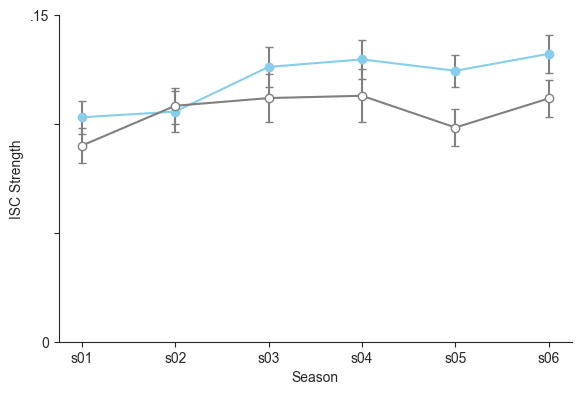

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
plt.figure(figsize=(6, 4))

# Define color mapping
custom_palette = {'laughter': 'skyblue', 'no_laughter': 'gray'}

# Plot lines without markers
sns.lineplot(
    data=mean_df,
    x="season", y="ISC",
    hue='condition',
    palette=custom_palette,
    errorbar=None,
    legend=False  # we'll manually create legend
)

# Add error bars and custom markers
for _, row in mean_df.iterrows():
    color = custom_palette[row['condition']]
    if row['condition'] == 'laughter':
        plt.errorbar(
            x=row['season'],
            y=row['ISC'],
            yerr=row['sem'],
            fmt='o',
            color=color,
            ecolor='gray',
            capsize=3,
            markersize=6,
            markerfacecolor=color,
            markeredgecolor=color
        )
    else:  # no_laughter
        plt.errorbar(
            x=row['season'],
            y=row['ISC'],
            yerr=row['sem'],
            fmt='o',
            color=color,
            ecolor='gray',
            capsize=3,
            markersize=6,
            markerfacecolor='white',
            markeredgecolor=color
        )

# Labels and style
plt.xlabel("Season")
plt.ylabel("ISC Strength")
plt.ylim(0, 0.15)
plt.grid(False)
sns.despine()
plt.tight_layout()

plt.yticks([0, 0.05, 0.1, 0.15], ['0', '', '', '.15'])


# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='skyblue', label='Laughter',
           markerfacecolor='skyblue', markersize=6),
    Line2D([0], [0], marker='o', color='gray', label='No Laughter',
           markerfacecolor='white', markeredgewidth=1.5, markeredgecolor='gray', markersize=6)
]
#plt.legend(handles=legend_elements, title='Condition')

plt.show()


### now the seasons

In [239]:
seasons = ['s01', 's02', 's03', 's04', 's05', 's06']

(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)


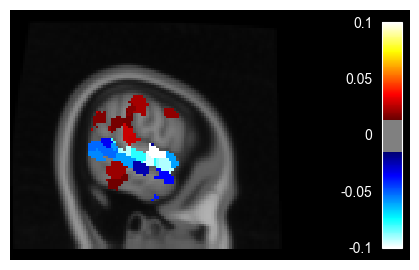

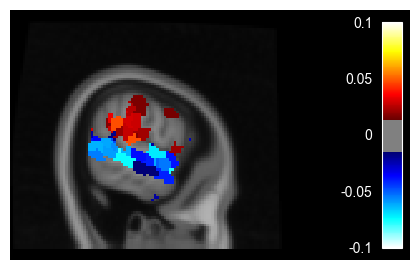

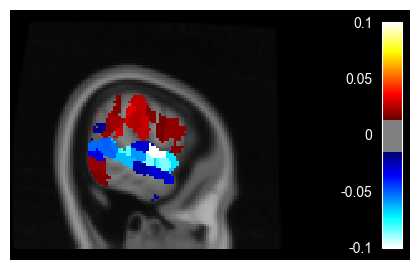

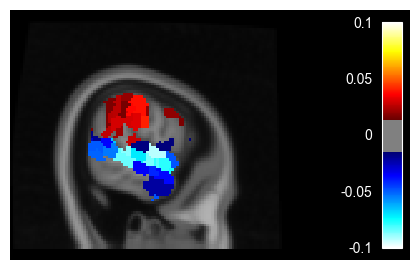

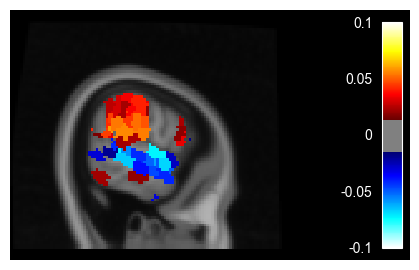

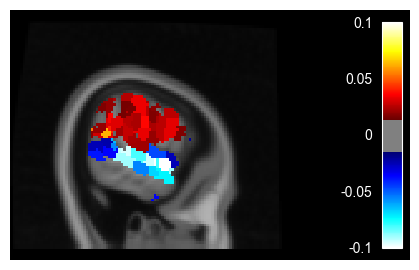

In [240]:
for curr_season in seasons:

    mask = df_names['season'] == curr_season
    matching_indices = df_names.index[mask]
    
    
    curr_season_laughter_iscs    = laughter_iscs[matching_indices, :]
    curr_season_no_laughter_iscs = no_laughter_iscs[matching_indices, :]
    
    isc_difference =  fisher_z_to_r(np.mean(curr_season_laughter_iscs, axis=0) - np.mean(curr_season_no_laughter_iscs, axis=0) )
    
    # Perform paired t-test for each region (axis=0 across subjects)
    t_values = np.zeros(1000)
    p_values = np.zeros(1000)
    
    for i in range(1000):
        t_stat, p_val = ttest_rel(curr_season_laughter_iscs[:, i], curr_season_no_laughter_iscs[:, i])
        t_values[i] = t_stat
        p_values[i] = p_val
    
    # Now you have arrays of t-values and p-values for each region
    #print(t_values.shape)  # (1000,)
    #print(p_values.shape)  # (1000,)
    
    significant_mask, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    significant_mask = np.ones(1000, dtype=bool)
    # Which regions are significant?
    #significant_indices = np.where(significant_mask)[0]
    
    significant_isc_differences = np.zeros((1000,))
    significant_isc_differences[significant_mask] = isc_difference[significant_mask]
    
    isc_r_brain = roi_to_brain(pd.Series(significant_isc_differences), mask_x).to_nifti()
    #result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(np.asarray(p_results), q = alpha)).to_nifti()
    
    
    fig = plt.figure(figsize=(4, 2.5))
    display = nilearn.plotting.plot_stat_map(    isc_r_brain, 
                                           bg_img       = '../data/MNI152_T1_2mm.nii.gz',
                                           threshold    = 0.015,  #additional threshold for visualization
                                           vmax         = 0.1, 
                                           draw_cross   = False,
                                           display_mode = 'x',
                                           cut_coords   = [ 62],
                                           annotate     = False,
                                           figure = fig)
                                           #title = 'ISC No-Laughter Scenes (across episodes)');
    plt.show()
    
    # Add overlay to the same display
    #overlay_img = '../data/tpj_association-test_z_FDR_0.01.nii.gz'
    #display.add_overlay(overlay_img, cmap='Greens', threshold=0.1, alpha=0.6)

### overall

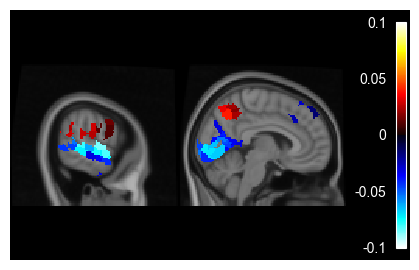

In [248]:
  
isc_difference =  fisher_z_to_r(np.mean(laughter_iscs, axis=0) - np.mean(no_laughter_iscs, axis=0) )
    
# Perform paired t-test for each region (axis=0 across subjects)
t_values = np.zeros(1000)
p_values = np.zeros(1000)
    
for i in range(1000):
        t_stat, p_val = ttest_rel(curr_season_laughter_iscs[:, i], curr_season_no_laughter_iscs[:, i])
        t_values[i] = t_stat
        p_values[i] = p_val
    
     
significant_mask, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
#significant_mask = np.ones(1000, dtype=bool)
    
significant_isc_differences = np.zeros((1000,))
significant_isc_differences[significant_mask] = isc_difference[significant_mask]
    
isc_r_brain = roi_to_brain(pd.Series(significant_isc_differences), mask_x).to_nifti()
     
    
fig = plt.figure(figsize=(4, 2.5))
display = nilearn.plotting.plot_stat_map(    isc_r_brain, 
                                           bg_img       = '../data/MNI152_T1_2mm.nii.gz',
                                           threshold    = 0.00,  #additional threshold for visualization
                                           vmax         = 0.1, 
                                           draw_cross   = False,
                                           display_mode = 'x',
                                           cut_coords   = [ 62, 5],
                                           annotate     = False,
                                           figure = fig)
                                           #title = 'ISC No-Laughter Scenes (across episodes)');
plt.show()
    
